**Triangulacja Delaunay’a** chmury punktów 2D z wykorzystaniem algorytmu
iteracyjnego – analiza metod znajdowania trójkąta, do którego trafia punkt
Należy zaimplementować iteracyjny algorytm konstrukcji triangulacji Delaunay’a dla chmury
punktów w 2D omawiany na wykładzie. Należy zaimplementować co najmniej dwie różne
metody wyszukiwania trójkąta, do którego trafia nowo wprowadzany punkt. Program
powinien pozwolić na wizualizację działania programu. Przeprowadzić analizę efektywności
dla dużych zbiorów punktów wraz z porównaniem efektywności poszczególnych etapów
algorytmu. Porównać także oba warianty metody wyszukiwania trójkąta.


[WIKIPEDIA](https://en.wikipedia.org/wiki/Delaunay_triangulation)

In [1]:
#importy
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from random import randint

In [2]:
#globalny epsilon
EPS = 0

In [30]:
#TODO:  napisanie det4 do is_in_circumcircle (done + zrobione geometryczne [mozna zrobic porownanie])
#       Walking search [done]
#       wprowadzanie punków z myszki (mogę wrzucić swój kod później)
#       Testy

In [31]:
import tkinter as tk
from tkinter import filedialog, messagebox
import json
import matplotlib
import matplotlib.lines
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Ustawienie backendu
matplotlib.use("TkAgg")

root = tk.Tk()
root.title("tniap")
root.geometry("500x500")

fig = Figure(figsize=(5, 3), dpi=100)
ax = fig.add_subplot(111)

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

points = []
counter = [0]

def on_click(event):
    if event.xdata is None or event.ydata is None:
        return

    point = (event.xdata, event.ydata)
    counter[0] += 1
    points.append(point)


    ax.scatter(*points[-1], color='#014EFF')
    canvas.draw()

def save_to_json():
    if not points:
        return
    file_path = filedialog.asksaveasfilename(
        defaultextension=".json",
        filetypes=[("Pliki JSON", "*.json")]
    )
    if file_path:
        try:
            with open(file_path, 'w') as f:
                json.dump(points, f)
            print(f"Zapisano: {file_path}")
        except Exception as e:
            print(f"Błąd zapisu: {e}")

def clear_canvas():
    points.clear()
    counter[0] = 0
    ax.clear()
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    canvas.draw()

canvas = FigureCanvasTkAgg(fig, master=root)
canvas.draw()
canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

canvas.mpl_connect("button_press_event", on_click)

btn_frame = tk.Frame(root)
btn_frame.pack(fill=tk.X, side=tk.BOTTOM, pady=5)

btn_save = tk.Button(btn_frame, text="Zapisz do JSON", command=save_to_json)
btn_save.pack(side=tk.LEFT, padx=10)

btn_clear = tk.Button(btn_frame, text="Wyczyść", command=clear_canvas)
btn_clear.pack(side=tk.LEFT, padx=10)

root.mainloop()

Exception in callback <_asyncio.TaskStepMethWrapper object at 0x0000022EB4F976A0>()
handle: <Handle <_asyncio.TaskStepMethWrapper object at 0x0000022EB4F976A0>()>
Traceback (most recent call last):
  File "C:\Users\pawel\AppData\Local\Python\pythoncore-3.14-64\Lib\asyncio\events.py", line 94, in _run
    self._context.run(self._callback, *self._args)
    ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Cannot enter into task <Task pending name='Task-124' coro=<Kernel.shell_main() running at c:\Users\pawel\Desktop\Computational-geometry\venv\Lib\site-packages\ipykernel\kernelbase.py:590> cb=[Task.task_wakeup()]> while another task <Task pending name='Task-123' coro=<Kernel.enter_eventloop.<locals>.advance_eventloop() running at c:\Users\pawel\Desktop\Computational-geometry\venv\Lib\site-packages\ipykernel\kernelbase.py:514> cb=[_wrap_awaitable.<locals>.<lambda>() at c:\Users\pawel\Desktop\Computational-geometry\venv\Lib\site-packages\tornado\gen.py:868, IOLoop.add_future.<lo

In [3]:

class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def distance(self, other):
    return ((self.x - other.x)**2 + (self.y - other.y)**2)

  def subtract(self, other):
    return Point(self.x - other.x, self.y - other.y)

  def __eq__(self, other):
    return self.distance(other) <= EPS

  def __hash__(self):
    return hash((round(self.x,5),round(self.x,5)))

  def __repr__(self):
    return f"({self.x}, {self.y})"


In [4]:
class Edge:
  def __init__(self, p1, p2):
    self.p1 = p1
    self.p2 = p2

  def __eq__(self, other):
    if not isinstance(other, Edge):
            return False
    return (self.p1 == other.p1 and self.p2 == other.p2 or self.p1==other.p2 and self.p2==other.p1)
  def __hash__(self):
    s = hash(self.p1)
    b = hash(self.p2)
    return hash((min(s,b),max(s,b)))

  def __repr__(self):
    return f"Edge({self.p1}, {self.p2})"

In [5]:

def orient(a,b,c):
    return (b.x-a.x)*(c.y-a.y)-(c.x-a.x)*(b.y-a.y)
#CCW > 0
class Triangle:
  def __init__(self, p1, p2, p3):
    if orient(p1,p2,p3) < 0:
      self.p1 = p1
      self.p2 = p3
      self.p3 = p2
    else:
      self.p1 = p1
      self.p2 = p2
      self.p3 = p3
    self.edges = [Edge(self.p1, self.p2), Edge(self.p2, self.p3), Edge(self.p3, self.p1)]
    self.neighbours = [None,None,None]
    self.is_bad = False
  def is_inside(self, p):
    return (    orient(self.p1, self.p2, p) >=0
            and orient(self.p2, self.p3, p) >=0
            and orient(self.p3, self.p1, p) >=0)
  def is_in_circumcircle(self, p):
    px, py = p.x, p.y
    p1x, p1y = self.p1.x, self.p1.y
    p2x, p2y = self.p2.x, self.p2.y
    p3x, p3y = self.p3.x, self.p3.y

    ax_ = p1x - px
    ay_ = p1y - py
    bx_ = p2x - px
    by_ = p2y - py
    cx_ = p3x - px
    cy_ = p3y - py

    det_a = ax_ * ax_ + ay_ * ay_
    det_b = bx_ * bx_ + by_ * by_
    det_c = cx_ * cx_ + cy_ * cy_

    det = (ax_ * (by_ * det_c - det_b * cy_) -
           ay_ * (bx_ * det_c - det_b * cx_) +
           det_a * (bx_ * cy_ - by_ * cx_))

    return det > EPS

  def __repr__(self):
    return f"Triangle({self.p1}, {self.p2}, {self.p3})"

  def __eq__(self, other):
      if not isinstance(other, Triangle):
          return False
      vertices_self = {self.p1, self.p2, self.p3}
      vertices_other = {other.p1, other.p2, other.p3}
      return vertices_self == vertices_other

  def __hash__(self):
      return hash(self.p1) ^ hash(self.p2) ^ hash(self.p3)


In [6]:
def SuperTriangle(cloud):
  """
  cloud to chmura punktów [Point(x1,y1),Point(x2,y2)...]
  """
  maxX = -float('inf')
  minX = float('inf')
  maxY = -float('inf')
  minY = float('inf')
  for p in cloud:
    x = p.x
    y = p.y
    if x > maxX:
      maxX = x
    if x < minX:
      minX = x
    if y > maxY:
      maxY = y
    if y < minY:
      minY = y

  dx = maxX - minX
  dy = maxY - minY
  delta = max(dx, dy)
  if delta == 0: delta = 1

  p1 = Point((minX + maxX) / 2, maxY + 20 * delta)
  p2 = Point(minX - 20 * delta, minY - delta)
  p3 = Point(maxX + 20 * delta, minY - delta)

  return Triangle(p1, p2, p3)

In [7]:
def naiveSearch(points):
    # 1. Inicjalizacja
    triangulation = set()
    super=SuperTriangle(points)
    triangulation.add(super)

    for p in points:
        removed = set()
        visited = set()  # Visited musi być czyszczone dla każdego punktu!

        # --- POPRAWKA 1: PRAWIDŁOWY DFS ---
        def dfs(t):
            visited.add(t)
            if t.is_in_circumcircle(p):
                removed.add(t)
                # Sprawdzamy sąsiadów
                for n in t.neighbours:
                    if n is not None and n not in visited:
                        dfs(n) # USUNIĘTO 'return', teraz sprawdzi wszystkich sąsiadów

        # Znajdź trójkąt startowy i uruchom DFS
        for t in triangulation:
            if t.is_inside(p):
                dfs(t)
                break

        # --- POPRAWKA 2: ZNAJDOWANIE KRAWĘDZI WRAZ Z SĄSIADAMI ---
        # Zamiast 'edges = set()' (XOR), używamy mapy: Krawędź -> Stary Sąsiad
        boundary = {}

        for t in removed:
            for i, edge in enumerate(t.edges):
                neighbor = t.neighbours[i]

                # Jeśli sąsiada nie ma w 'removed', to jest to krawędź graniczna
                if neighbor not in removed:
                    boundary[edge] = neighbor

        # Usuwamy złe trójkąty
        for t in removed:
            triangulation.remove(t)

        # --- TWORZENIE NOWYCH I ŁĄCZENIE SĄSIADÓW ---
        new_triangles = [] # Lista nowych trójkątów w tym kroku

        for edge, outer_neighbor in boundary.items():
            newT = Triangle(edge.p1, edge.p2, p)
            new_triangles.append(newT)
            triangulation.add(newT)

            # 1. Połącz z ZEWNĘTRZNYM (starym) sąsiadem
            # Szukamy krawędzi 'edge' w nowym trójkącie (zazwyczaj indeks 0)
            for i, e_new in enumerate(newT.edges):
                if e_new == edge:
                    newT.neighbours[i] = outer_neighbor

                    # Ważne: Stary sąsiad też musi wskazywać na nowy trójkąt!
                    if outer_neighbor:
                        for j, e_old in enumerate(outer_neighbor.edges):
                            if e_old == edge:
                                outer_neighbor.neighbours[j] = newT
                                break
                    break

        # 2. Połącz NOWE trójkąty między sobą (Twoje 'ns' - poprawione)
        # Używamy mapy do sklejenia boków wychodzących z punktu P
        shared_edges = {}
        for t in new_triangles:
            for i, e in enumerate(t.edges):
                # Jeśli to krawędź graniczna (nie dotyka P), pomijamy
                if e in boundary: continue

                if e in shared_edges:
                    other = shared_edges[e]
                    # Łączymy t i other
                    t.neighbours[i] = other
                    # Musimy znaleźć indeks w 'other'
                    for j, e_other in enumerate(other.edges):
                        if e_other == e:
                            other.neighbours[j] = t
                            break
                else:
                    shared_edges[e] = t
    superPs = set([super.p1,super.p2,super.p3])
    toRemove=set([])
    for t in triangulation:
        if t.p1 in superPs or t.p2 in superPs or t.p3 in superPs:
          toRemove.add(t)
    return triangulation.difference(toRemove)

In [ ]:
def walkingSearch0(points):
    # 1. Inicjalizacja
    triangulation = set()

    # Zakładam, że klasa SuperTriangle jest zdefiniowana wcześniej
    super_t = SuperTriangle(points)
    triangulation.add(super_t)

    # Zmienna do przechowywania trójkąta startowego dla Walking Search
    last_triangle = super_t

    for p in points:
        removed = set()
        visited = set()

        # --- KROK 1: WALKING SEARCH (POPRAWIONE) ---
        # Przekazujemy 'triangulation' jako trzeci argument!
        bad_triangle = walking_search(last_triangle, p, triangulation)

        # --- KROK 2: DFS (szukanie wnęki) ---
        def dfs(t):
            if t in visited: return
            visited.add(t)

            # Jeśli punkt p leży w okręgu opisanym na t
            if t.is_in_circumcircle(p):
                removed.add(t)
                # Sprawdzamy sąsiadów
                for n in t.neighbours:
                    if n is not None:
                        dfs(n)

        # Uruchamiamy DFS od znalezionego trójkąta
        dfs(bad_triangle)

        # --- KROK 3: ZNAJDOWANIE KRAWĘDZI GRANICZNYCH ---
        boundary = {}
        for t in removed:
            for i, edge in enumerate(t.edges):
                neighbor = t.neighbours[i]
                if neighbor not in removed:
                    boundary[edge] = neighbor

        # Usuwamy złe trójkąty z głównego zbioru
        for t in removed:
            triangulation.remove(t)

        # --- KROK 4: TWORZENIE NOWYCH I ŁĄCZENIE ---
        new_triangles = []

        for edge, outer_neighbor in boundary.items():
            newT = Triangle(edge.p1, edge.p2, p)
            new_triangles.append(newT)
            triangulation.add(newT)

            # Połącz z zewnętrznym sąsiadem (który przetrwał)
            for i, e_new in enumerate(newT.edges):
                if e_new == edge:
                    newT.neighbours[i] = outer_neighbor
                    if outer_neighbor:
                        for j, e_old in enumerate(outer_neighbor.edges):
                            if e_old == edge:
                                outer_neighbor.neighbours[j] = newT
                                break
                    break

        # Połącz nowe trójkąty między sobą (wewnątrz wnęki)
        shared_edges = {}
        for t in new_triangles:
            for i, e in enumerate(t.edges):
                if e in boundary: continue # Krawędzie zewnętrzne już obsłużyliśmy

                if e in shared_edges:
                    other = shared_edges[e]
                    t.neighbours[i] = other
                    # Szukamy, która to krawędź u sąsiada
                    for j, e_other in enumerate(other.edges):
                        if e_other == e:
                            other.neighbours[j] = t
                            break
                else:
                    shared_edges[e] = t

        # Aktualizacja trójkąta startowego dla następnego punktu
        # Dzięki temu walking search zacznie blisko nowego punktu
        if new_triangles:
            last_triangle = new_triangles[0]

    # --- CZYSZCZENIE ---
    # Usuwamy trójkąty powiązane z SuperTriangle
    superPs = set([super_t.p1, super_t.p2, super_t.p3])
    toRemove = set()
    for t in triangulation:
        if t.p1 in superPs or t.p2 in superPs or t.p3 in superPs:
            toRemove.add(t)

    return triangulation.difference(toRemove)

In [37]:
def walking_search(start_triangle, p, all_triangles_list):
    """
    start_triangle: punkt startowy spaceru
    p: szukany punkt
    all_triangles_list: referencja do całej listy/zbioru trójkątów (na wypadek awarii spaceru)
    """
    current_t = start_triangle
    visited_local = set() # Pamięć trójkątów odwiedzonych TYLKO w tym spacerze

    while True:
        visited_local.add(current_t)
        moved = False

        # Sprawdzamy krawędzie
        for i in range(3):
            # Używamy orientacji, aby sprawdzić czy punkt jest "na zewnątrz"
            # Zakładamy CCW: jeśli < 0, to punkt jest po prawej stronie krawędzi
            edge_p1 = current_t.p1 if i==0 else (current_t.p2 if i==1 else current_t.p3)
            edge_p2 = current_t.p2 if i==0 else (current_t.p3 if i==1 else current_t.p1)

            # Używamy -EPS dla bezpieczeństwa numerycznego
            if orient(edge_p1, edge_p2, p) < -EPS:
                neighbor = current_t.neighbours[i]

                # Przypadek 1: Trafiliśmy na granicę całego obszaru (SuperTriangle)
                if neighbor is None:
                    return current_t

                # Przypadek 2: Wykryto pętlę (cykl) - błąd numeryczny
                if neighbor in visited_local:
                    break

                # Idziemy do sąsiada
                current_t = neighbor
                moved = True
                break # Przerywamy pętlę for, zaczynamy while od nowego trójkąta

        if not moved:
            # Jesteśmy w środku!
            return current_t

        # Jeśli pętla for skończyła się breakiem z powodu cyklu
        if not moved and len(visited_local) > 1:
             break

    # --- FALLBACK (PLAN B) ---
    # Jeśli spacer zawiódł (cykl), szukamy liniowo w całej liście.
    for t in all_triangles_list:
        if t.is_inside(p):
            return t

    return start_triangle # Ostateczność

In [8]:
def is_in_circumcircle_geometric(self, p):
    # Pobieramy współrzędne
    x1, y1 = self.p1.x, self.p1.y
    x2, y2 = self.p2.x, self.p2.y
    x3, y3 = self.p3.x, self.p3.y

    # Wyznacznik D (podwojone pole trójkąta)
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    # Jeśli D jest bliskie 0, punkty są współliniowe (nie tworzą trójkąta)
    if abs(D) < EPS:
        return False

    # Obliczamy środek okręgu opisanego (Ux, Uy)
    Ux = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    Uy = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D

    # Promień do kwadratu (odległość środka od p1)
    r_sq = (x1 - Ux)**2 + (y1 - Uy)**2

    # Odległość punktu p od środka do kwadratu
    dist_sq = (p.x - Ux)**2 + (p.y - Uy)**2

    # Jeśli odległość punktu jest mniejsza niż promień -> jest w środku
    return dist_sq < r_sq - EPS # Odejmujemy EPS dla bezpieczeństwa

In [39]:
def fast_determinant_check(p1x, p1y, p2x, p2y, p3x, p3y, px, py, eps):
    ax_ = p1x - px
    ay_ = p1y - py
    bx_ = p2x - px
    by_ = p2y - py
    cx_ = p3x - px
    cy_ = p3y - py

    det_a = ax_ * ax_ + ay_ * ay_
    det_b = bx_ * bx_ + by_ * by_
    det_c = cx_ * cx_ + cy_ * cy_

    det = (ax_ * (by_ * det_c - det_b * cy_) -
           ay_ * (bx_ * det_c - det_b * cx_) +
           det_a * (bx_ * cy_ - by_ * cx_))

    return det > eps

class Triangle:
    # ... (reszta Twojej klasy) ...

    def is_in_circumcircle(self, p):
        # Klasa jest tylko "opakowaniem", cała robota dzieje się w skompilowanej funkcji
        return fast_determinant_check(
            self.p1.x, self.p1.y,
            self.p2.x, self.p2.y,
            self.p3.x, self.p3.y,
            p.x, p.y,
            EPS
        )

In [9]:
def is_outside(edge, p, triangle):
    # Prosty test znaku pola (orientacji)
    # Zwraca True, jeśli punkt p leży po prawej stronie krawędzi (edge.p1 -> edge.p2)
    # przy założeniu, że wnętrze trójkąta jest po lewej.
    val = (edge.p2.y - edge.p1.y) * (p.x - edge.p2.x) - \
          (edge.p2.x - edge.p1.x) * (p.y - edge.p2.y)
    return val > 0 # Jeśli dodatnie, punkt jest "na zewnątrz"

In [10]:
def walkingSearch(points):
    # 1. Inicjalizacja super-trójkąta [cite: 440, 442]
    triangulation = set()
    st = SuperTriangle(points) 
    triangulation.add(st)
    
    # Startowa wskazówka dla lokalizacji [cite: 514]
    last_found = st

    for p in points:
        # --- ETAP 1: LOKALIZACJA (Walking Search) [cite: 508, 509] ---
        curr = last_found
        visited_walk = set()
        found_triangle = None
        
        while curr is not None:
            if curr in visited_walk: # Zabezpieczenie przed zapętleniem
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break
            
            visited_walk.add(curr)
            
            if curr.is_inside(p):
                found_triangle = curr
                break
            
            # Wybór krawędzi w kierunku punktu 
            moved = False
            for i, edge in enumerate(curr.edges):
                if is_outside(edge, p, curr): 
                    next_tri = curr.neighbours[i]
                    if next_tri is not None:
                        curr = next_tri
                        moved = True
                        break
            
            if not moved: # Fallback
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break

        if found_triangle is None: continue

        # --- ETAP 2: BUDOWA KAWERNY (DFS) [cite: 469, 471] ---
        removed = set()
        visited_dfs = set()

        def dfs(t):
            visited_dfs.add(t)
            if t.is_in_circumcircle(p):
                removed.add(t)
                for n in t.neighbours:
                    if n is not None and n not in visited_dfs:
                        dfs(n)

        dfs(found_triangle)

        # --- ETAP 3: RE-TRIANGULACJA WNĘKI [cite: 475, 476] ---
        boundary = {} # Krawędź -> Zewnętrzny Sąsiad
        for t in removed:
            for i, edge in enumerate(t.edges):
                neighbor = t.neighbours[i]
                if neighbor not in removed:
                    boundary[edge] = neighbor

        for t in removed:
            triangulation.remove(t)

        # Tworzenie nowych trójkątów i mapowanie sąsiedztwa
        new_triangles = []
        edge_to_new_tri = {} # Mapa dla wewnętrznych krawędzi (wychodzących z p)

        for edge, outer_neighbor in boundary.items():
            newT = Triangle(edge.p1, edge.p2, p)
            new_triangles.append(newT)
            triangulation.add(newT)

            # Połączenie ze starym sąsiadem zewnętrznym
            for i, e in enumerate(newT.edges):
                if e == edge:
                    newT.neighbours[i] = outer_neighbor
                    if outer_neighbor:
                        for j, ne_edge in enumerate(outer_neighbor.edges):
                            if ne_edge == edge:
                                outer_neighbor.neighbours[j] = newT
                    break

        # ŁĄCZENIE NOWYCH TRÓJKĄTÓW MIĘDZY SOBĄ (Kluczowe dla Walking Search!)
        for nt in new_triangles:
            for i, e in enumerate(nt.edges):
                if nt.neighbours[i] is not None: continue # Już połączony z zewnętrznym
                
                if e in edge_to_new_tri:
                    other_nt, other_idx = edge_to_new_tri[e]
                    nt.neighbours[i] = other_nt
                    other_nt.neighbours[other_idx] = nt
                else:
                    edge_to_new_tri[e] = (nt, i)

        if new_triangles:
            last_found = new_triangles[0]

    # --- ETAP 4: CZYSZCZENIE (Poza pętlą punktów!) [cite: 504, 506] ---
    superPs = {st.p1, st.p2, st.p3}
    final_triangulation = set()
    for t in triangulation:
        if not (t.p1 in superPs or t.p2 in superPs or t.p3 in superPs):
            final_triangulation.add(t)
            
    return final_triangulation

In [11]:
import time
ns = []
ws = []
ys = []
for i,n in enumerate([100,200,300,400,800,1600,3200,6600,7800,10000,20000]):
    Points = [Point(np.random.uniform(-100*(i+1),100*(i+1)),np.random.uniform(-100*(i+1),100*(i+1))) for _ in range(n)]
    start = time.perf_counter()
    # naiveSearch(Points)
    # end = time.perf_counter()
    # ns.append(end-start)
    # start = time.perf_counter()
    walkingSearch(Points)
    end = time.perf_counter()
    ws.append(end-start)
    ys.append(n)
    

[0.038023500000008426, 0.07568579999997382, 0.14151129999999057, 0.16280690000002096, 0.37682150000000547, 0.8692057999999747, 2.3774199999999723, 5.387824000000023, 6.670642300000054, 9.418275699999981, 24.169144099999983]


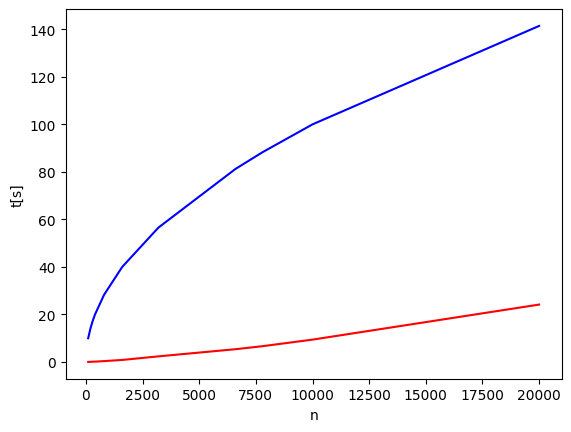

In [14]:
print(ws)
plt.plot(ys,ws, c = 'red')
plt.plot(ys,np.array(ys)**(1/2),c = 'blue')

plt.ylabel("t[s]")
plt.xlabel("n")
plt.show()


In [ ]:
# --- NOWA FUNKCJA POMOCNICZA (CORE LOGIC) ---
def add_point_to_triangulation(triangulation, p, start_triangle):
    removed = set()
    visited_dfs = set()

    # 1. DFS - szukamy trójkątów do usunięcia (nielegalnych)
    def dfs(t):
        visited_dfs.add(t)
        if t.is_in_circumcircle(p):
            removed.add(t)
            for n in t.neighbours:
                if n is not None and n not in visited_dfs:
                    dfs(n)
    
    dfs(start_triangle)

    # 2. Znajdowanie boundary (granicy wnęki)
    boundary = {} # Krawędź -> Zewnętrzny Sąsiad
    
    for t in removed:
        for i, edge in enumerate(t.edges):
            neighbor = t.neighbours[i]
            # Jeśli sąsiada nie ma w 'removed', to jest to krawędź graniczna
            if neighbor not in removed:
                boundary[edge] = neighbor

    # 3. Usuwanie starych trójkątów
    for t in removed:
        triangulation.remove(t)

    # 4. Tworzenie nowych trójkątów i łączenie z zewnętrzem
    new_triangles = []
    
    for edge, outer_neighbor in boundary.items():
        # Tworzymy nowy trójkąt łączący krawędź graniczną z nowym punktem P
        newT = Triangle(edge.p1, edge.p2, p)
        new_triangles.append(newT)
        triangulation.add(newT)

        # Łączenie z ZEWNĘTRZNYM (starym) sąsiadem
        # Musimy znaleźć, która krawędź w nowym trójkącie to 'edge'
        for i, e_new in enumerate(newT.edges):
            if e_new == edge:
                newT.neighbours[i] = outer_neighbor
                
                # Aktualizacja wskazania w starym sąsiedzie
                if outer_neighbor:
                    for j, e_old in enumerate(outer_neighbor.edges):
                        if e_old == edge:
                            outer_neighbor.neighbours[j] = newT
                            break
                break

    # 5. Łączenie NOWYCH trójkątów między sobą
    # Krawędzie wychodzące z punktu P są wspólne dla nowych trójkątów
    shared_edges = {}
    
    for t in new_triangles:
        for i, e in enumerate(t.edges):
            # Pomijamy krawędzie graniczne (już połączone z boundary)
            if e in boundary: continue

            if e in shared_edges:
                other = shared_edges[e]
                # Łączymy t i other
                t.neighbours[i] = other
                
                # Znajdź indeks w 'other'
                for j, e_other in enumerate(other.edges):
                    if e_other == e:
                        other.neighbours[j] = t
                        break
            else:
                shared_edges[e] = t
    
    return new_triangles # Zwracamy listę nowych trójkątów


def clean_super_triangle(triangulation, st):
    # Tworzymy zbiór wierzchołków super-trójkąta dla szybkiego sprawdzania
    super_verts = {st.p1, st.p2, st.p3}
    toRemove = set()
    
    for t in triangulation:
        if t.p1 in super_verts or t.p2 in super_verts or t.p3 in super_verts:
            toRemove.add(t)
            
    # Czyścimy referencje sąsiadów w pozostawionych trójkątach 
    # (żeby nie wskazywały na usunięte), choć w Pythoie GC to załatwi, 
    # dla czystości topologicznej można by ustawić na None.
    
    return triangulation.difference(toRemove)


# --- METODA 1: NAIVE SEARCH ---
def naiveSearch(points):
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)

    for p in points:
        start_triangle = None
        # Proste przeszukiwanie liniowe
        for t in triangulation:
            if t.is_inside(p):
                start_triangle = t
                break
        
        # Jeśli z jakiegoś powodu (błędy numeryczne) nie znaleziono, 
        # można spróbować przeszukać ponownie z większym marginesem, 
        # ale w idealnym przypadku zawsze się znajdzie (dzięki SuperTriangle)
        
        if start_triangle:
            add_point_to_triangulation(triangulation, p, start_triangle)

    return clean_super_triangle(triangulation, st)


# --- METODA 2: WALKING SEARCH ---
def walkingSearch(points):
    triangulation = set()
    st = SuperTriangle(points)
    triangulation.add(st)
    
    last_found = st

    for p in points:
        curr = last_found
        visited_walk = set()
        found_triangle = None
        
        # Algorytm spaceru
        while curr is not None:
            if curr in visited_walk:
                # Zapętlenie (rzadkie, ale możliwe przy błędach numerycznych).
                # Fallback do metody naiwnej.
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break
            
            visited_walk.add(curr)
            
            if curr.is_inside(p):
                found_triangle = curr
                break
            
            # Decyzja nawigacyjna: przez którą krawędź przejść?
            moved = False
            for i, edge in enumerate(curr.edges):
                if is_outside(edge, p, curr):
                    next_tri = curr.neighbours[i]
                    if next_tri is not None:
                        curr = next_tri
                        moved = True
                        break
            
            if not moved:
                # Punkt jest na zewnątrz obecnego trójkąta, ale nie ma sąsiada w tym kierunku.
                # Może się zdarzyć na granicy SuperTriangle lub przy błędach numerycznych.
                # Fallback.
                for t in triangulation:
                    if t.is_inside(p):
                        found_triangle = t
                        break
                break

        if found_triangle:
            new_tris = add_point_to_triangulation(triangulation, p, found_triangle)
            if new_tris:
                # Optymalizacja: następny punkt prawdopodobnie będzie blisko tego
                last_found = new_tris[0]
    print(1)
    return clean_super_triangle(triangulation, st)

In [17]:
import numpy as np
import time
ns = []
ws = []
ys = []
for i,n in enumerate([100,200,300,400,800,1600,3200,6600,7800,10000,20000]):
    Points = [Point(np.random.uniform(-100*(i+1),100*(i+1)),np.random.uniform(-100*(i+1),100*(i+1))) for _ in range(n)]
    start = time.perf_counter()
    r1=naiveSearch(Points)
    end = time.perf_counter()
    ns.append(end-start)

    start = time.perf_counter()
    r2 = walkingSearch(Points)
    end = time.perf_counter()
    ws.append(end-start)
    ys.append(n)

    print(r1 == r2)

True
True
True
True
True
True
True


KeyboardInterrupt: 